In [1]:
import numpy as np
import pandas as pd
import invert4geom

import xarray as xr

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
#from polartoolkit import fetch, maps, profiles, regions, utils

import polartoolkit as ptk

In [3]:
import os

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

region = ptk.regions.getz_ice_shelf
spacing = 4000

# 1.) Loading Datasets

In [4]:
constraint_points = pd.read_csv('constraint_points.csv')
constraint_points

easting      northing  bed_elevation
0     -1.559078e+06 -1.233548e+06   -3538.024543
1     -1.558187e+06 -1.233347e+06   -3531.229456
2     -1.557547e+06 -1.233500e+06   -3520.570221
3     -1.556466e+06 -1.233429e+06   -3513.796082
4     -1.555333e+06 -1.233868e+06   -3512.433386
...             ...           ...            ...
55221 -1.154000e+06 -6.640000e+05    -957.328003
55222 -1.152750e+06 -6.645000e+05    -961.495514
55223 -1.147000e+06 -6.640000e+05    -362.992767
55224 -1.136500e+06 -6.645000e+05     -96.594223
55225 -1.131000e+06 -6.640000e+05    -701.685425

[55226 rows x 3 columns]

In [5]:
bed_topography = ptk.fetch.bedmap3(layer="bed", region = region, reference="ellipsoid",spacing=spacing)

bed_topography = bed_topography.rename({'x': 'easting', 'y': 'northing'}).to_dataset(name = 'upward')

In [6]:
bed_topography

<xarray.Dataset> Size: 74kB
Dimensions:   (northing: 143, easting: 125)
Coordinates:
  * northing  (northing) float64 1kB -1.232e+06 -1.228e+06 ... -6.64e+05
  * easting   (easting) float64 1kB -1.624e+06 -1.62e+06 ... -1.128e+06
Data variables:
    upward    (northing, easting) float32 72kB -3.466e+03 -3.437e+03 ... -791.9

In [7]:
gravityanomaly = xr.load_dataset('gravityanomaly.nc')
gravityanomaly

<xarray.Dataset> Size: 3MB
Dimensions:                (northing: 286, easting: 248)
Coordinates:
  * northing               (northing) float64 2kB -1.234e+06 ... -6.64e+05
  * easting                (easting) float64 2kB -1.624e+06 ... -1.13e+06
Data variables:
    gravity_disturbance    (northing, easting) float64 567kB nan nan ... nan nan
    upward                 (northing, easting) float32 284kB 456.5 ... 2.227e+03
    surface_gravity        (northing, easting) float64 567kB -1.271 ... 35.26
    water_surface_gravity  (northing, easting) float64 567kB -0.1568 ... -1.184
    gravity_anomaly        (northing, easting) float64 567kB nan nan ... nan nan

In [8]:
gravityanomaly = xr.load_dataset('gravityanomaly.nc')

resampled_vars = []
for var in gravityanomaly.data_vars:
    resampled_vars.append(
        ptk.resample_grid(gravityanomaly[var], spacing=spacing).rename(var)
    )
gravityanomaly = xr.merge(resampled_vars).rename({'x': 'easting', 'y': 'northing'})
gravityanomaly

<xarray.Dataset> Size: 357kB
Dimensions:                (northing: 143, easting: 124)
Coordinates:
  * northing               (northing) float64 1kB -1.232e+06 ... -6.64e+05
  * easting                (easting) float64 992B -1.624e+06 ... -1.132e+06
Data variables:
    gravity_disturbance    (northing, easting) float32 71kB nan nan ... nan nan
    upward                 (northing, easting) float32 71kB 456.5 ... 2.227e+03
    surface_gravity        (northing, easting) float32 71kB -1.389 ... 42.57
    water_surface_gravity  (northing, easting) float32 71kB -0.1715 ... -1.395
    gravity_anomaly        (northing, easting) float32 71kB nan nan ... nan nan
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt grdsample @GMTAPI@-S-I-G-M-G-N-000000 -G@GMTAPI@-S-O-G...
    description:   
    actual_range:  [-99.44690704 159.92054749]
    long_name:     z

# 2.) Creating data instance

In [9]:
gravityanomaly = invert4geom.create_data(gravityanomaly, buffer_width=None, model_type='prisms')
gravityanomaly

<xarray.Dataset> Size: 357kB
Dimensions:                (northing: 143, easting: 124)
Coordinates:
  * northing               (northing) float64 1kB -1.232e+06 ... -6.64e+05
  * easting                (easting) float64 992B -1.624e+06 ... -1.132e+06
Data variables:
    gravity_disturbance    (northing, easting) float32 71kB nan nan ... nan nan
    upward                 (northing, easting) float32 71kB 456.5 ... 2.227e+03
    surface_gravity        (northing, easting) float32 71kB -1.389 ... 42.57
    water_surface_gravity  (northing, easting) float32 71kB -0.1715 ... -1.395
    gravity_anomaly        (northing, easting) float32 71kB nan nan ... nan nan
Attributes:
    region:        (-1624000.0, -1132000.0, -1232000.0, -664000.0)
    spacing:       4000.0
    buffer_width:  48000.0
    inner_region:  (-1576000.0, -1180000.0, -1184000.0, -712000.0)
    dataset_type:  data
    model_type:    prisms

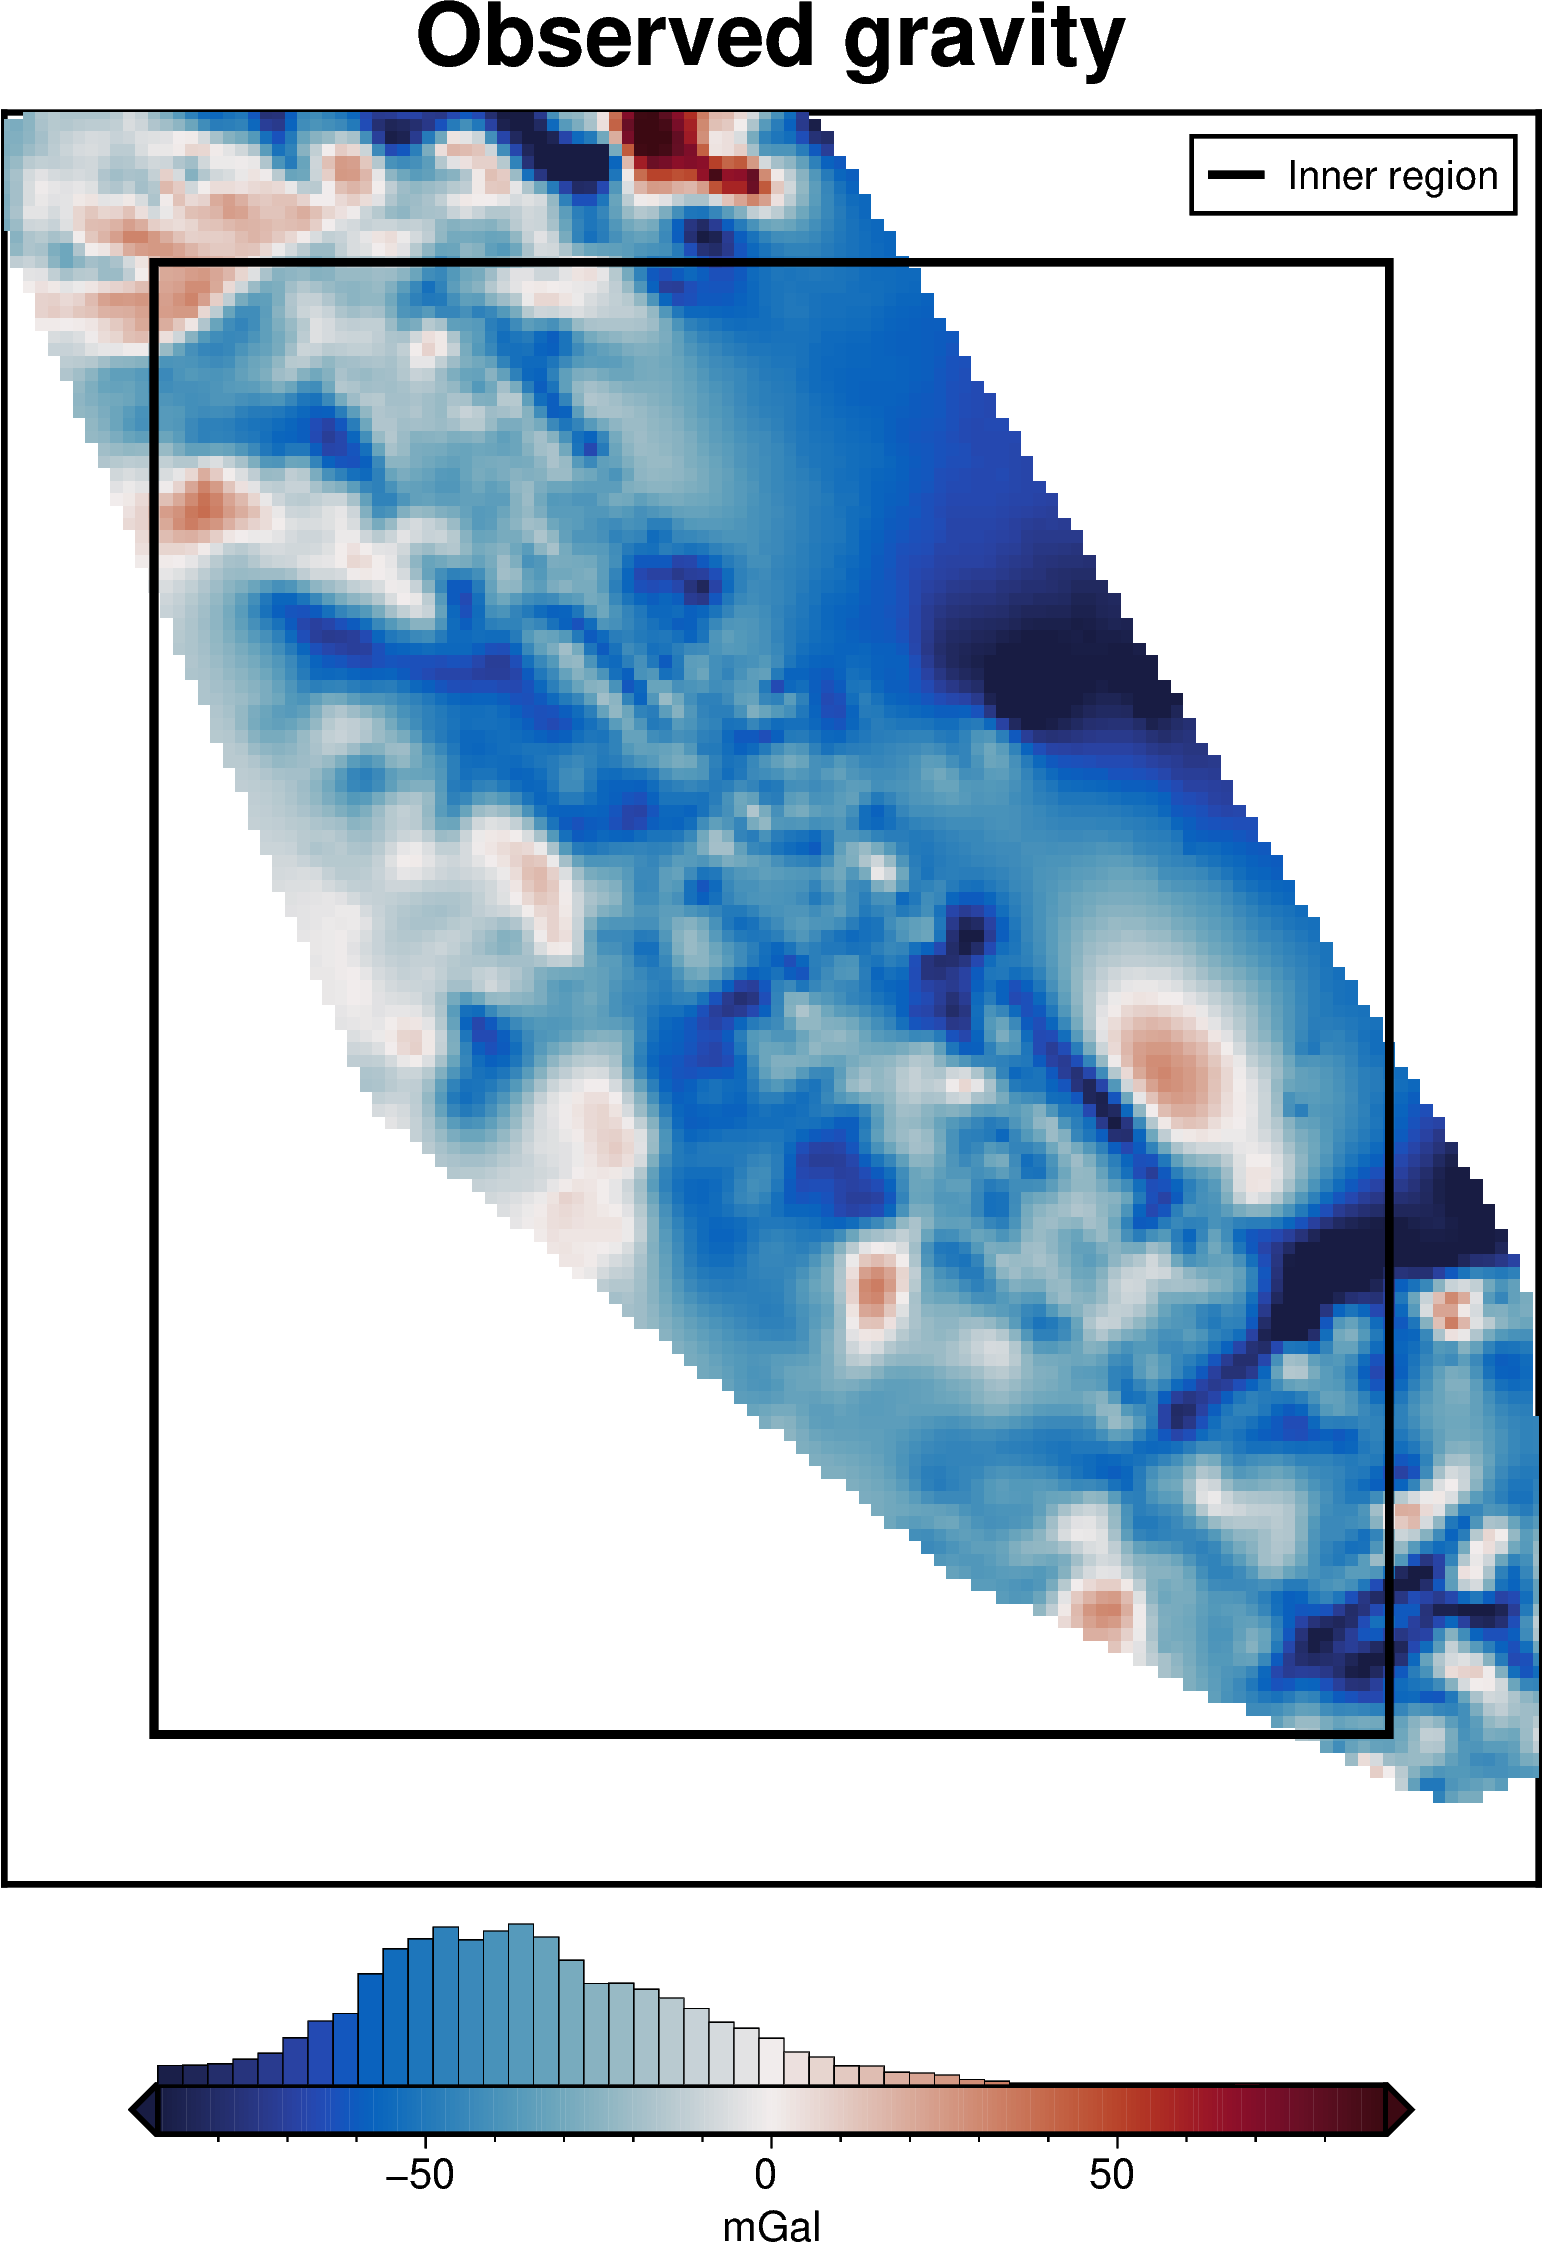

In [10]:
gravityanomaly.inv.plot_observed()

In [11]:
water_surface = ptk.fetch.bedmap3(layer = 'icebase', region = region, reference="ellipsoid",spacing = spacing)
water_surface = water_surface.rename( {'x': 'easting', 'y': 'northing'})


In [12]:
model = invert4geom.create_model(
     zref = 0,
     density_contrast= 1800 - 1030, topography = bed_topography, upper_confining_layer=water_surface

)
model

<xarray.Dataset> Size: 932kB
Dimensions:                (northing: 143, easting: 125)
Coordinates:
  * northing               (northing) float64 1kB -1.232e+06 ... -6.64e+05
  * easting                (easting) float64 1kB -1.624e+06 ... -1.128e+06
    top                    (northing, easting) float32 72kB 0.0 0.0 ... 0.0 0.0
    bottom                 (northing, easting) float64 143kB -3.466e+03 ... -...
Data variables:
    density                (northing, easting) int64 143kB -770 -770 ... -770
    thickness              (northing, easting) float64 143kB 3.466e+03 ... 791.9
    starting_topography    (northing, easting) float32 72kB -3.466e+03 ... -7...
    topography             (northing, easting) float32 72kB -3.466e+03 ... -7...
    mask                   (northing, easting) float32 72kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float32 72kB nan nan ... -781.8
    lower_confining_layer  (northing, easting) float64 143kB nan nan ... nan nan
Attributes:
    zref:              0
    density_contrast:  770
    region:            (-1624000.0, -1128000.0, -1232000.0, -664000.0)
    spacing:           4000.0
    buffer_width:      0
    inner_region:      (-1624000.0, -1128000.0, -1232000.0, -664000.0)
    dataset_type:      model
    model_type:        prisms

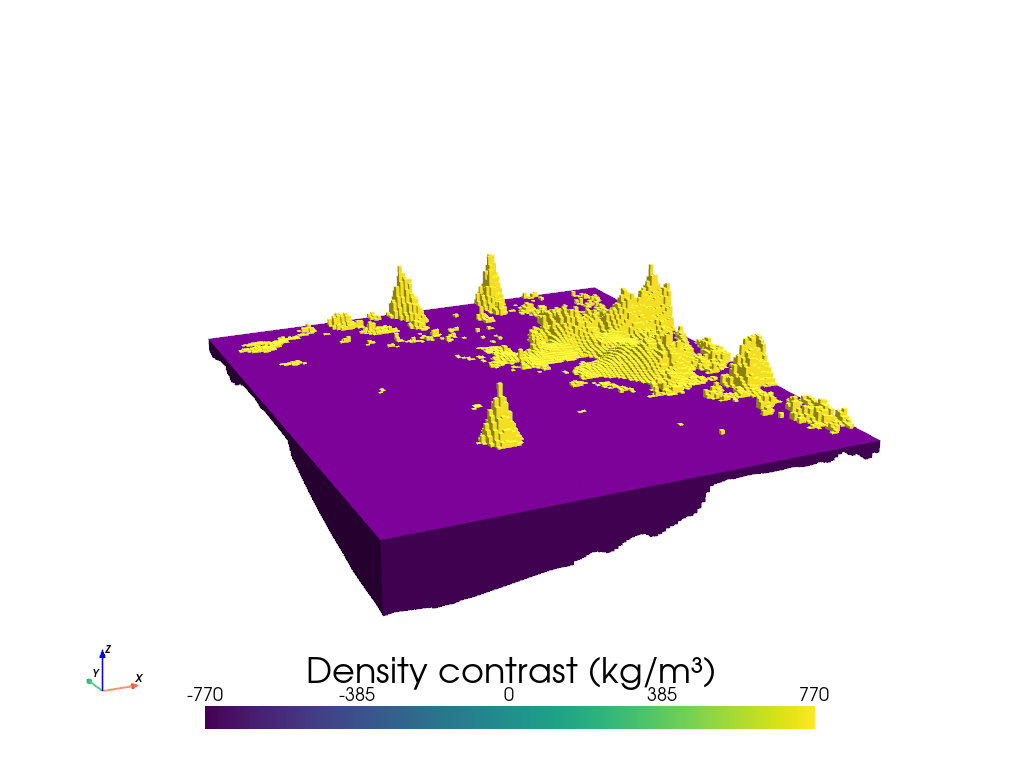

In [13]:
model.inv.plot_model(zscale = 20, color_by = 'density')

# 4.) calculated gravity effect of starting model

In [14]:
gravityanomaly.inv.forward_gravity(model, progressbar=True)
gravityanomaly


  0%|          | 0/9226 [00:00<?, ?it/s]

<xarray.Dataset> Size: 499kB
Dimensions:                (northing: 143, easting: 124)
Coordinates:
  * northing               (northing) float64 1kB -1.232e+06 ... -6.64e+05
  * easting                (easting) float64 992B -1.624e+06 ... -1.132e+06
Data variables:
    gravity_disturbance    (northing, easting) float32 71kB nan nan ... nan nan
    upward                 (northing, easting) float32 71kB 456.5 ... 2.227e+03
    surface_gravity        (northing, easting) float32 71kB -1.389 ... 42.57
    water_surface_gravity  (northing, easting) float32 71kB -0.1715 ... -1.395
    gravity_anomaly        (northing, easting) float32 71kB nan nan ... nan nan
    forward_gravity        (northing, easting) float64 142kB nan nan ... nan nan
Attributes:
    region:        (-1624000.0, -1132000.0, -1232000.0, -664000.0)
    spacing:       4000.0
    buffer_width:  48000.0
    inner_region:  (-1576000.0, -1180000.0, -1184000.0, -712000.0)
    dataset_type:  data
    model_type:    prisms

# 5.) Gravity misfit

In [15]:
# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
gravityanomaly.inv.regional_separation(
   constraints_df = constraint_points,
    method="constraints",
    tension_factor=0.3,
    grid_method= 'pygmt',
)
gravityanomaly

<xarray.Dataset> Size: 1MB
Dimensions:                   (northing: 143, easting: 124)
Coordinates:
  * northing                  (northing) float64 1kB -1.232e+06 ... -6.64e+05
  * easting                   (easting) float64 992B -1.624e+06 ... -1.132e+06
Data variables: (12/13)
    gravity_disturbance       (northing, easting) float32 71kB nan nan ... nan
    upward                    (northing, easting) float32 71kB 456.5 ... 2.22...
    surface_gravity           (northing, easting) float32 71kB -1.389 ... 42.57
    water_surface_gravity     (northing, easting) float32 71kB -0.1715 ... -1...
    gravity_anomaly           (northing, easting) float32 71kB nan nan ... nan
    forward_gravity           (northing, easting) float64 142kB nan nan ... nan
    ...                        ...
    reg                       (northing, easting) float32 71kB 71.11 ... -130.9
    res                       (northing, easting) float64 142kB nan nan ... nan
    starting_forward_gravity  (northing, easting) float64 142kB nan nan ... nan
    starting_misfit           (northing, easting) float64 142kB nan nan ... nan
    starting_reg              (northing, easting) float32 71kB 71.11 ... -130.9
    starting_res              (northing, easting) float64 142kB nan nan ... nan
Attributes:
    region:        (-1624000.0, -1132000.0, -1232000.0, -664000.0)
    spacing:       4000.0
    buffer_width:  48000.0
    inner_region:  (-1576000.0, -1180000.0, -1184000.0, -712000.0)
    dataset_type:  data
    model_type:    prisms

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\polartoolkit\maps.py:1422: UserWarning:

Since limits were passed to `cpt_lims`, parameter `robust` is unused.

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning:

Could not detect PROJ data files. Set PROJ_LIB environment variable to the correct path.

C:\Users\iii\miniforge3\envs\invert4geom\Lib\site-packages\polartoolkit\maps.py:1422: UserWarning:

Since limits were passed to `cpt_lims`, parameter `robust` is unused.



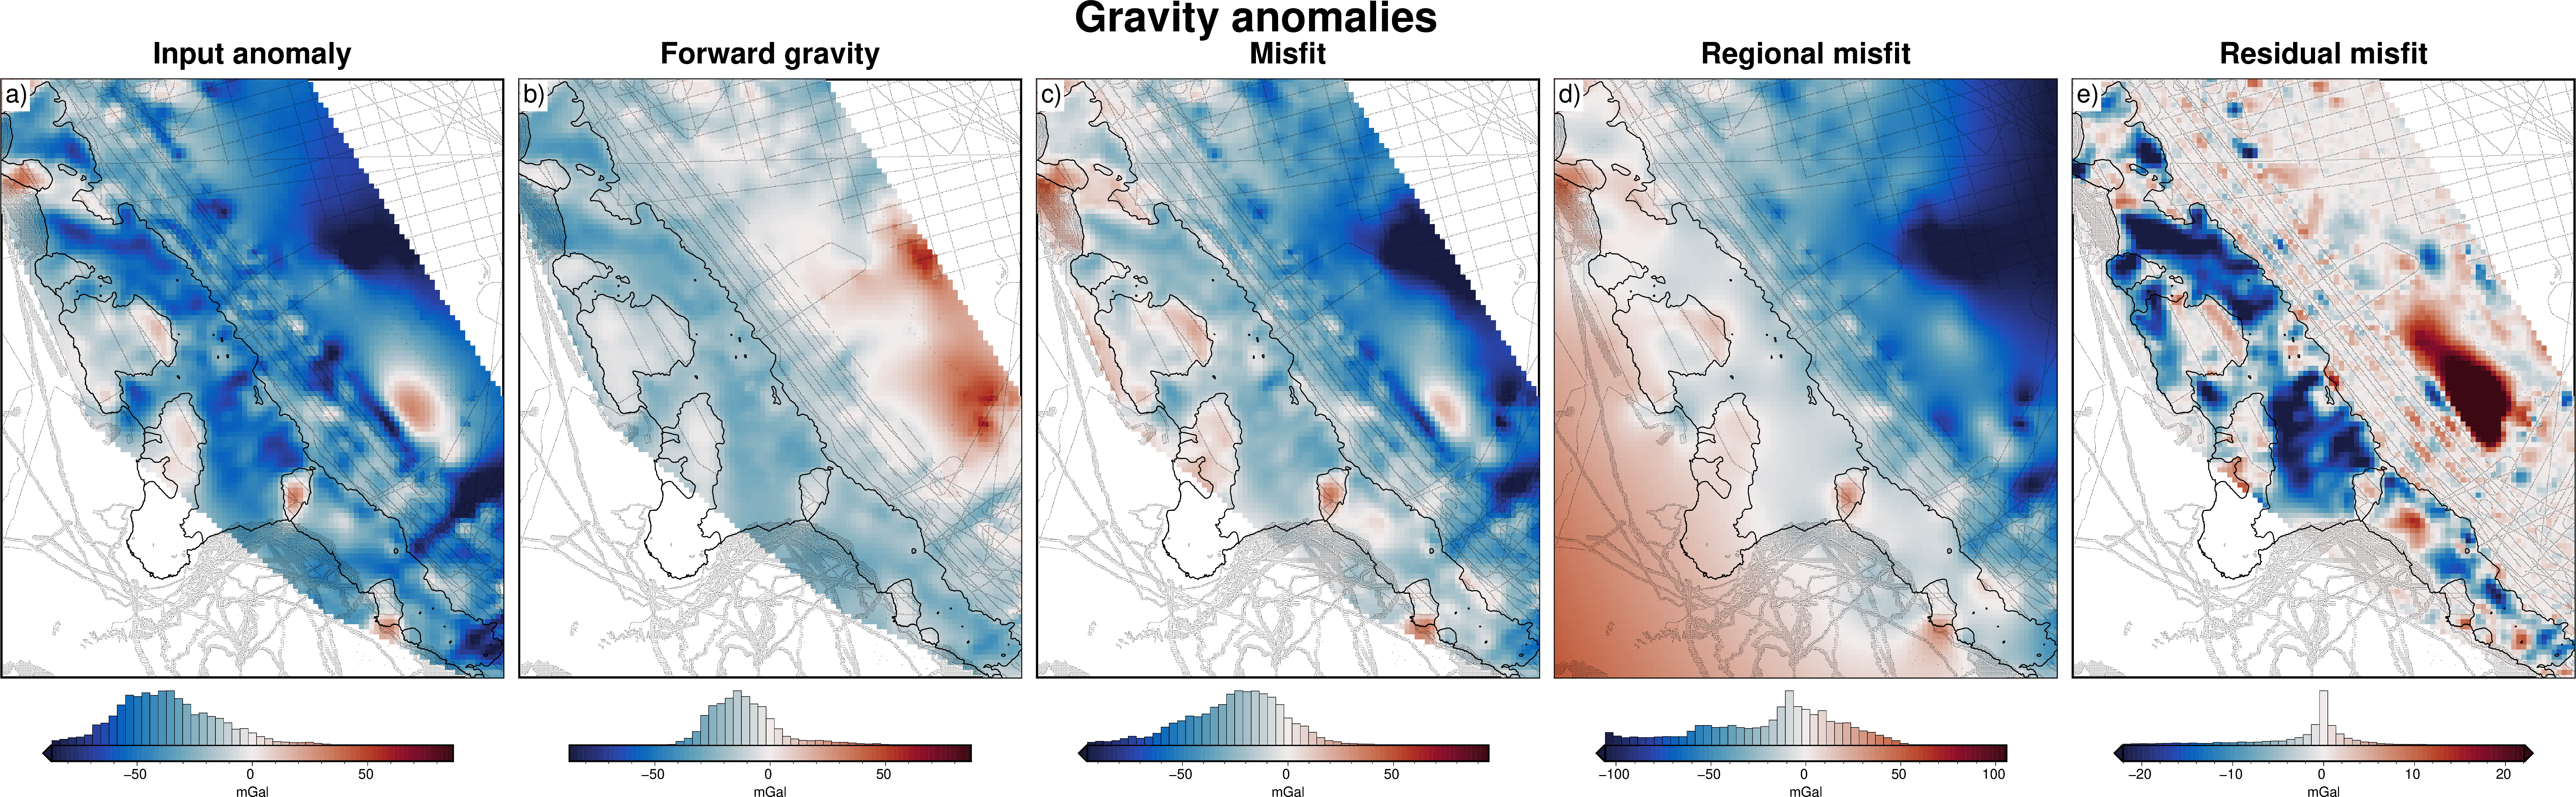

In [16]:
gravityanomaly.inv.plot_anomalies(coast=True, points=constraint_points, points_style='p.2p')

# 7.) Run Inversion

In [17]:
# setup the inversion
invs = invert4geom.Inversion(
    gravityanomaly,
    model,
    solver_damping=0.05,        #normal = 0.05
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=2,  # stop if L2-norm < 2 mGal (RMSE of 4 mGal)
    delta_l2_norm_tolerance=1.01,  # stop if iteration's change in L2-norm < 1%
)
invs.__dict__

{'data': <xarray.Dataset> Size: 1MB
 Dimensions:                   (northing: 143, easting: 124)
 Coordinates:
   * northing                  (northing) float64 1kB -1.232e+06 ... -6.64e+05
   * easting                   (easting) float64 992B -1.624e+06 ... -1.132e+06
 Data variables: (12/13)
     gravity_disturbance       (northing, easting) float32 71kB nan nan ... nan
     upward                    (northing, easting) float32 71kB 456.5 ... 2.22...
     surface_gravity           (northing, easting) float32 71kB -1.389 ... 42.57
     water_surface_gravity     (northing, easting) float32 71kB -0.1715 ... -1...
     gravity_anomaly           (northing, easting) float32 71kB nan nan ... nan
     forward_gravity           (northing, easting) float64 142kB nan nan ... nan
     ...                        ...
     reg                       (northing, easting) float32 71kB 71.11 ... -130.9
     res                       (northing, easting) float64 142kB nan nan ... nan
     starting_forward

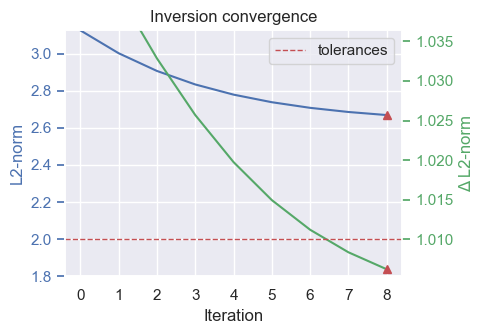

In [18]:
invs.invert(plot_dynamic_convergence=True)


In [19]:
invs.termination_reason

['delta l2-norm tolerance']

In [20]:
invs.stats_df

iteration      rmse   l2_norm  delta_l2_norm  iter_time_sec
0        0.0  9.771421  3.125927            inf            NaN
1        1.0  9.015291  3.002547       1.041092      18.470142
2        2.0  8.450770  2.907021       1.032861      16.578819
3        3.0  8.032611  2.834186       1.025699      15.736911
4        4.0  7.724503  2.779299       1.019749      15.380990
5        5.0  7.498745  2.738384       1.014941      15.534487
6        6.0  7.333652  2.708072       1.011193      15.901058
7        7.0  7.212804  2.685666       1.008343      14.997285
8        8.0  7.124251  2.669129       1.006196      15.662274

In [21]:
invs.model

<xarray.Dataset> Size: 7MB
Dimensions:                (northing: 143, easting: 125)
Coordinates:
  * northing               (northing) float64 1kB -1.232e+06 ... -6.64e+05
  * easting                (easting) float64 1kB -1.624e+06 ... -1.128e+06
    top                    (northing, easting) float64 143kB 0.0 0.0 ... 0.0 0.0
    bottom                 (northing, easting) float64 143kB -3.466e+03 ... -...
Data variables: (12/48)
    density                (northing, easting) int64 143kB -770 -770 ... -770
    thickness              (northing, easting) float64 143kB 3.466e+03 ... 791.9
    starting_topography    (northing, easting) float32 72kB -3.466e+03 ... -7...
    topography             (northing, easting) float64 143kB -3.466e+03 ... -...
    mask                   (northing, easting) float32 72kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float32 72kB nan nan ... -781.8
    ...                     ...
    topography_correction  (northing, easting) float64 143kB 0.004399 ... 0.0...
    iter_8_top             (northing, easting) float64 143kB 0.0 0.0 ... 0.0 0.0
    iter_8_bottom          (northing, easting) float64 143kB -3.466e+03 ... -...
    iter_8_density         (northing, easting) int64 143kB -770 -770 ... -770
    iter_8_layer           (northing, easting) float64 143kB -3.466e+03 ... -...
    iter_8_correction      (northing, easting) float64 143kB 0.004399 ... 0.0...
Attributes:
    zref:              0
    density_contrast:  770
    region:            (-1624000.0, -1128000.0, -1232000.0, -664000.0)
    spacing:           4000.0
    buffer_width:      0
    inner_region:      (-1624000.0, -1128000.0, -1232000.0, -664000.0)
    dataset_type:      model
    model_type:        prisms

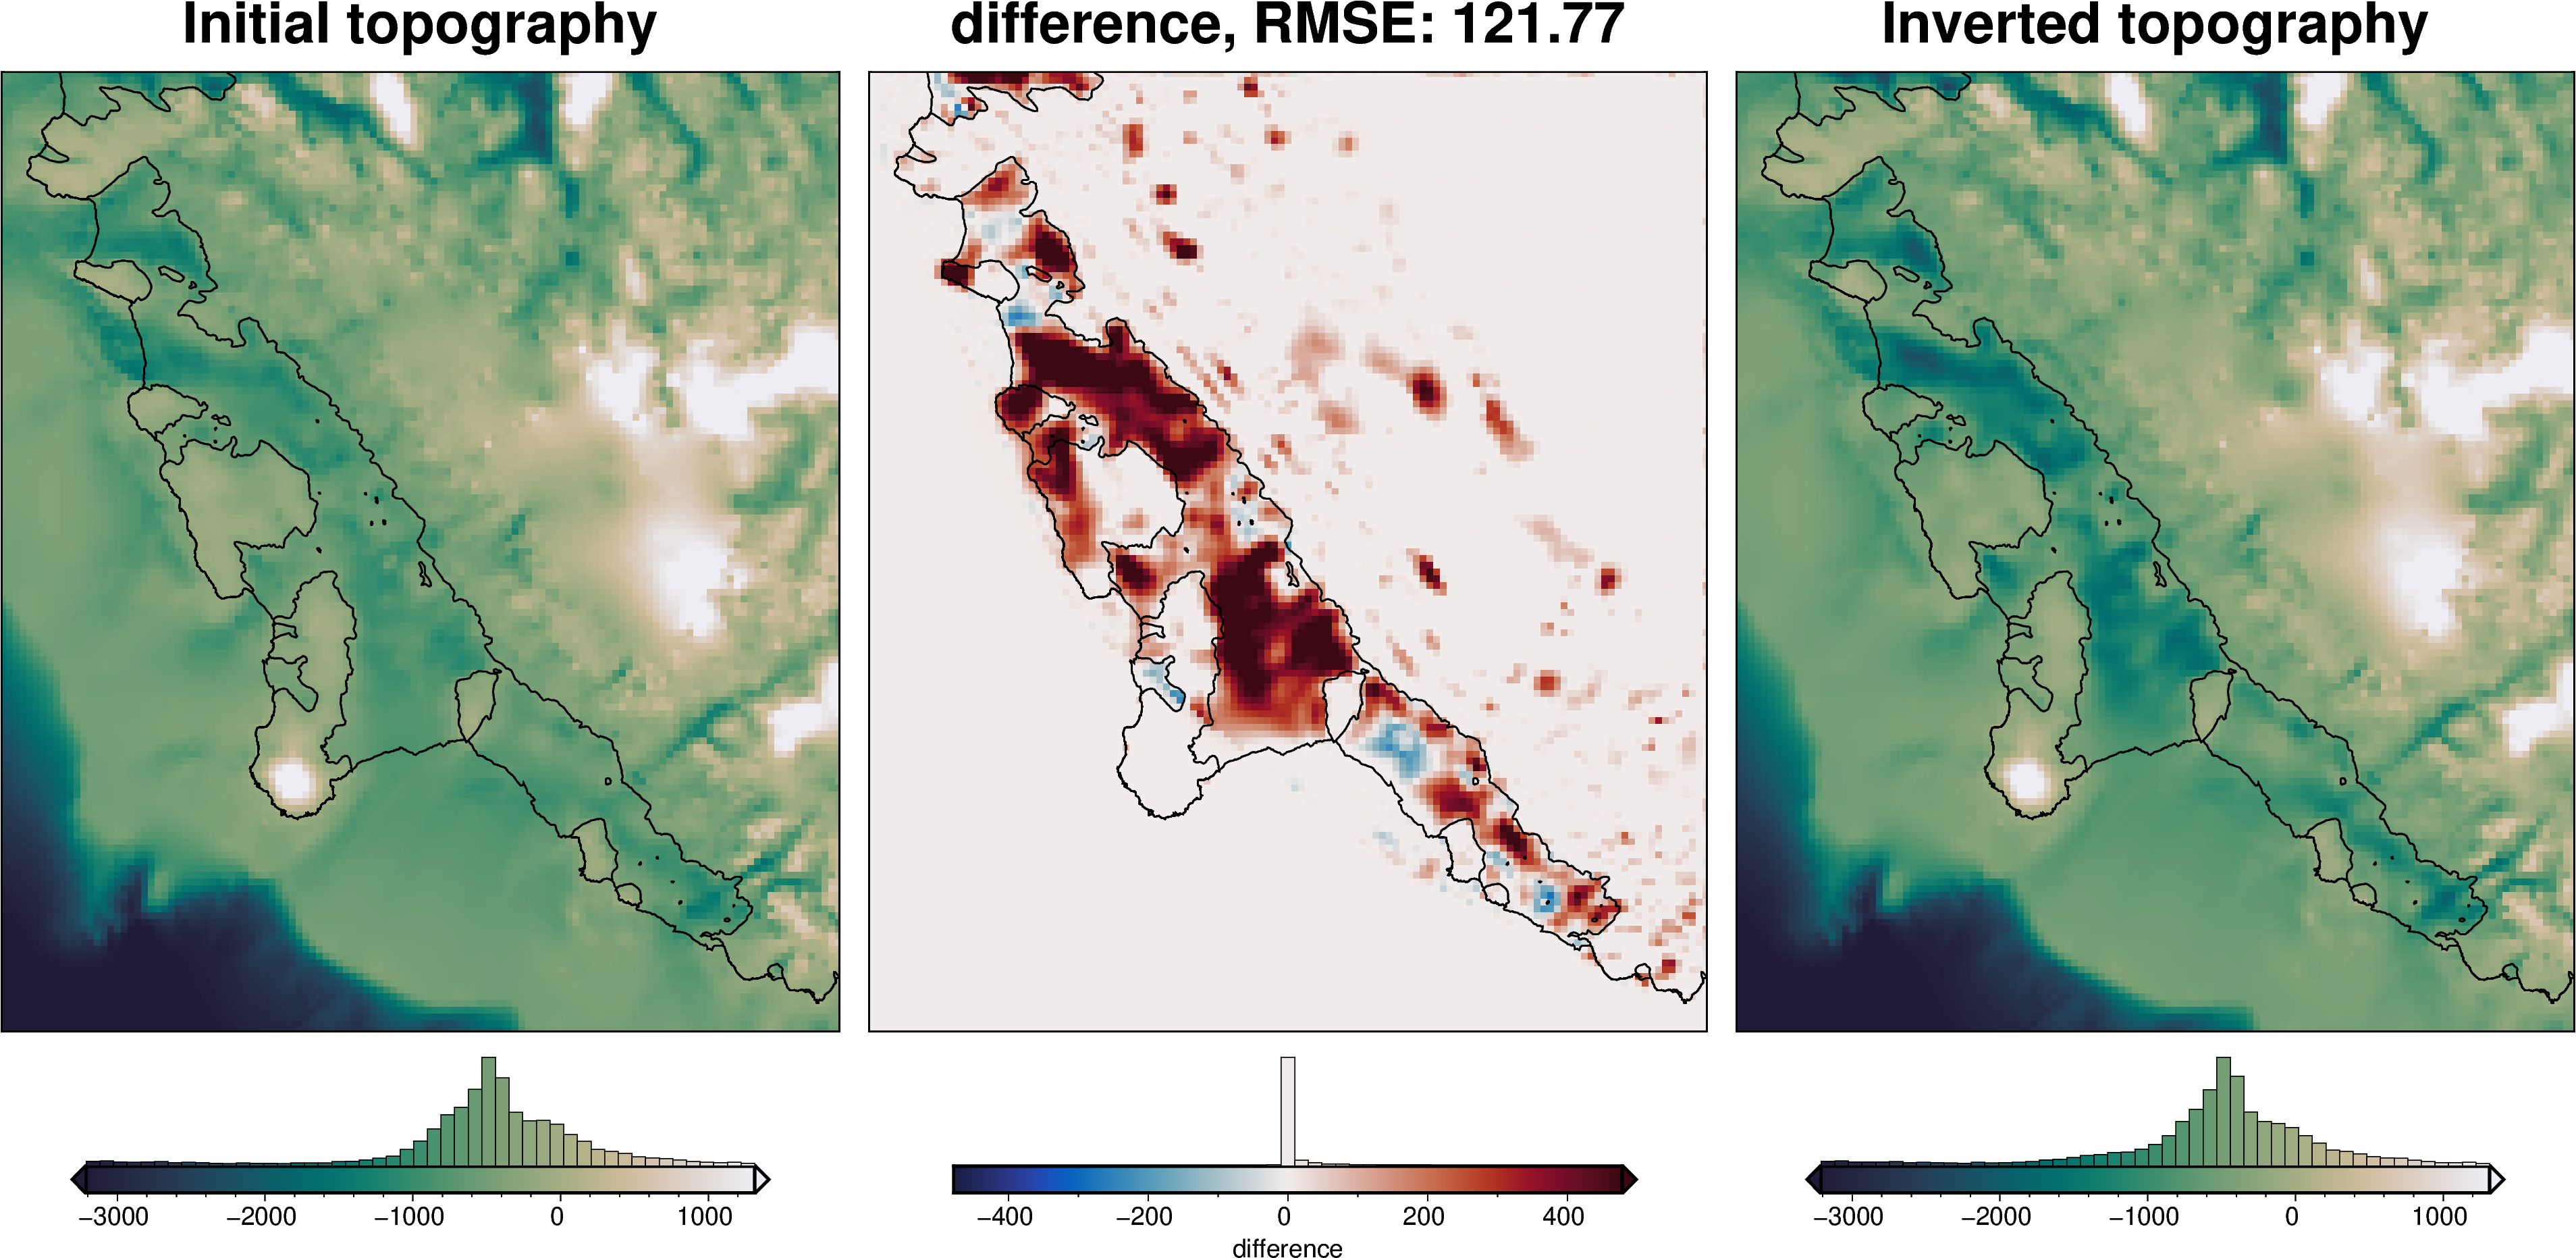

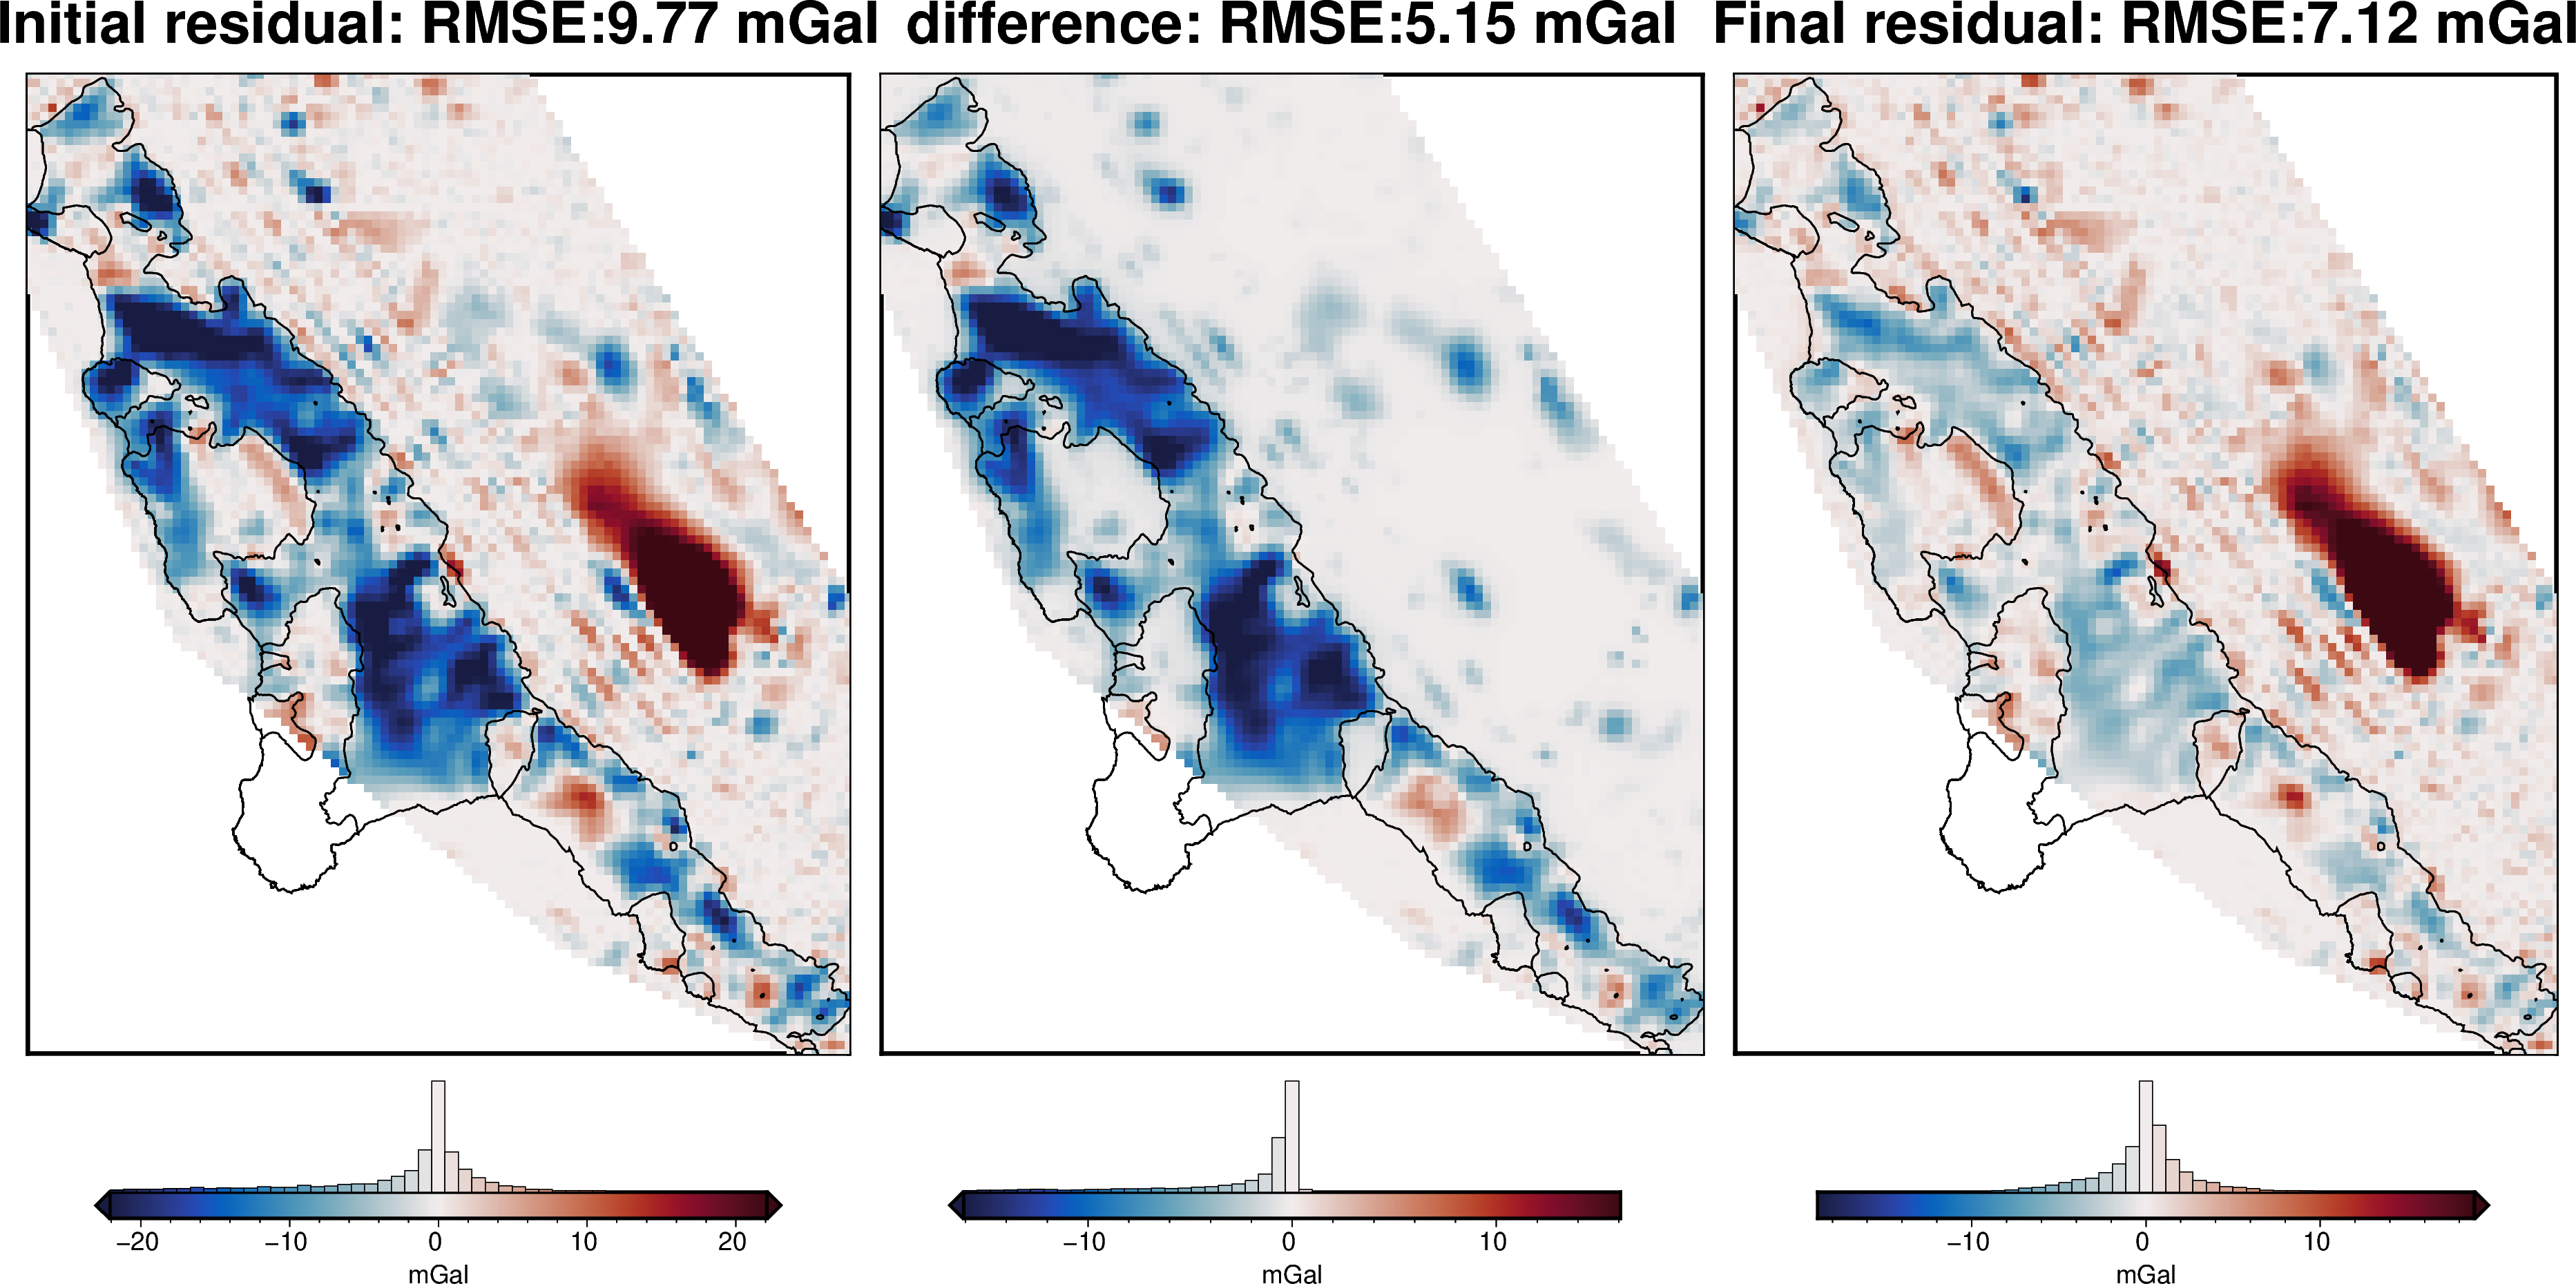

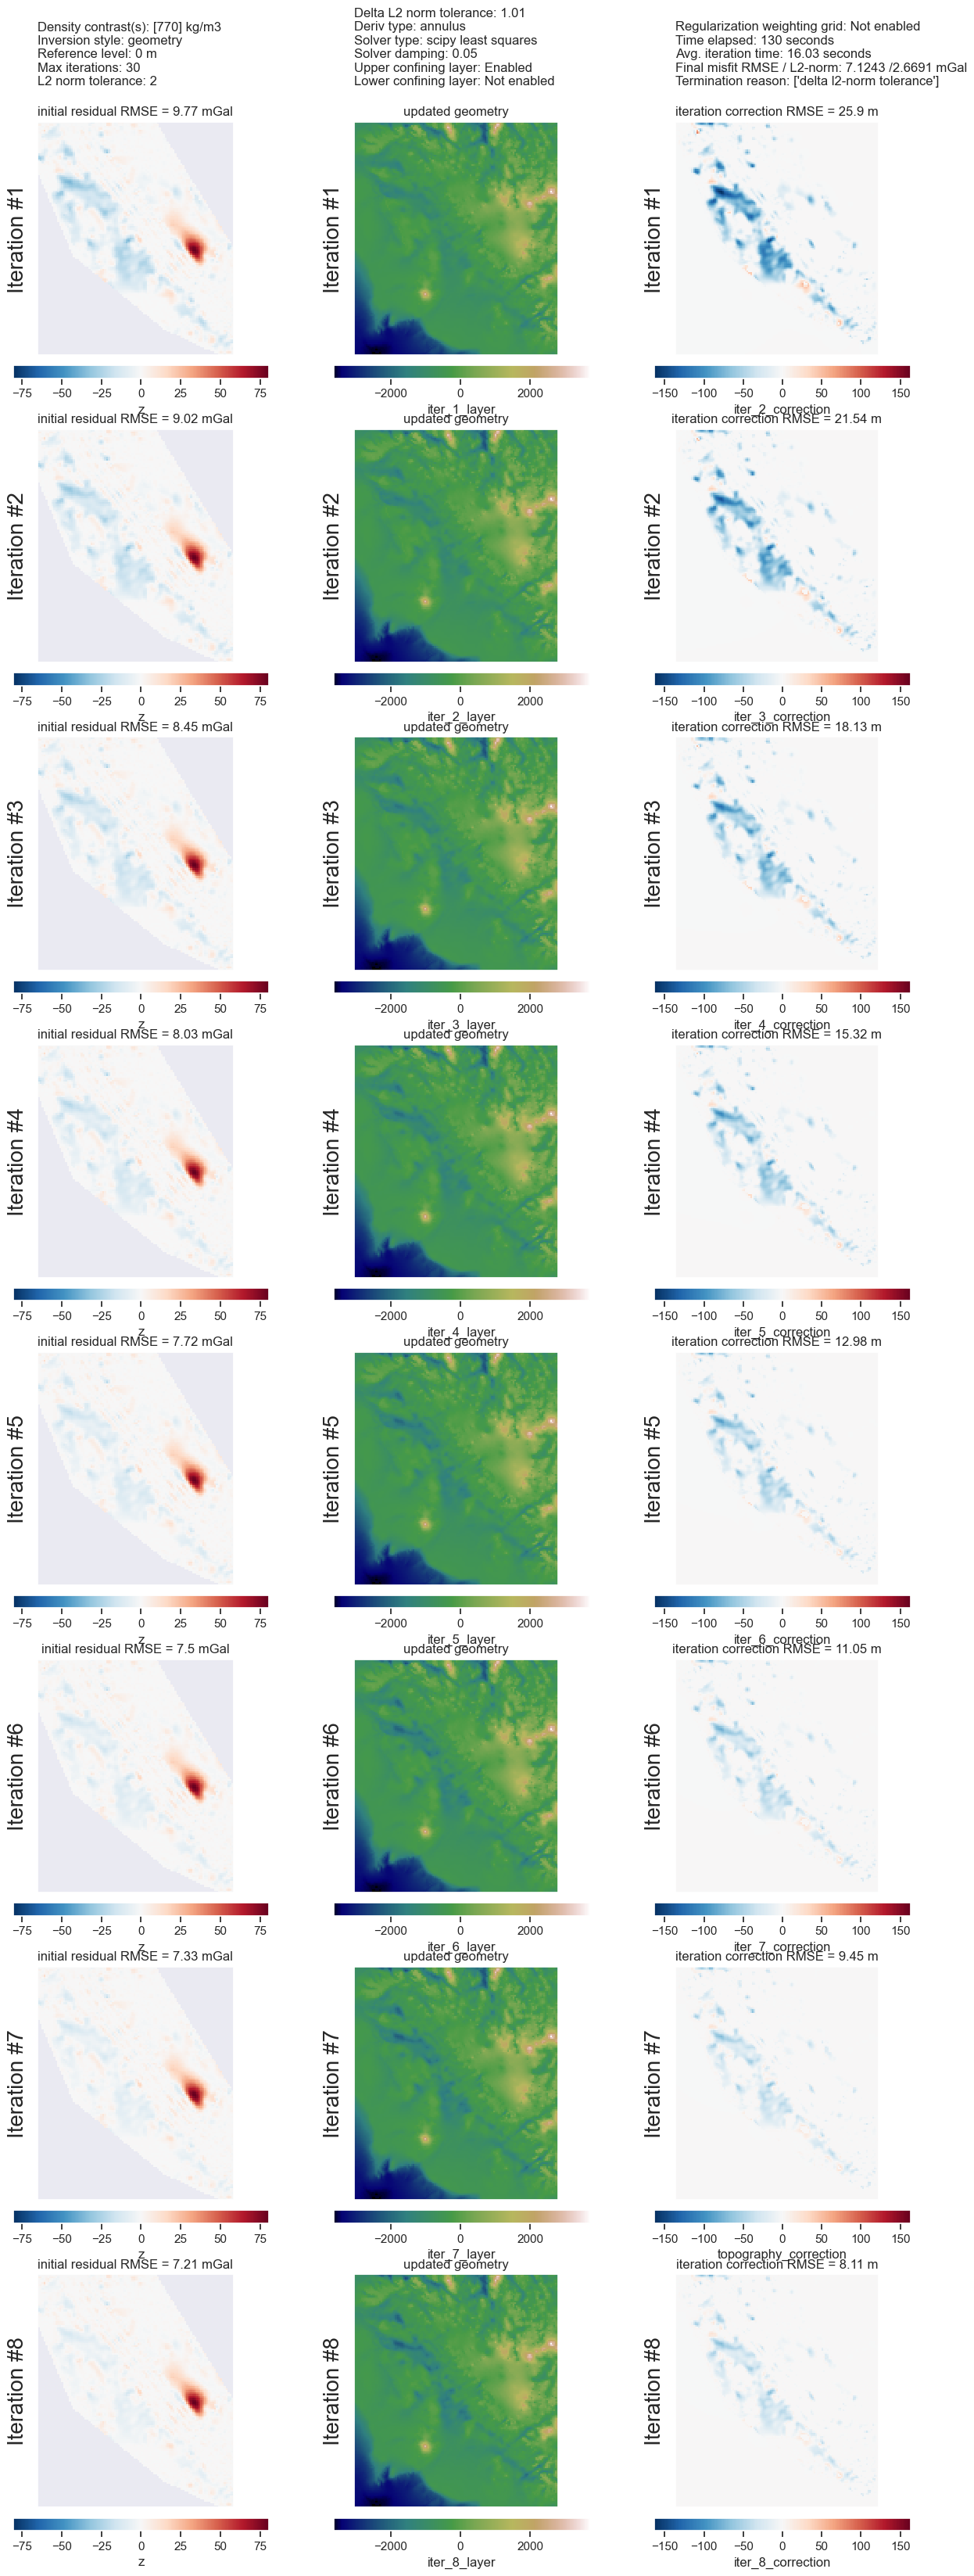

In [22]:
invs.plot_inversion_results(
    coast=True,
)

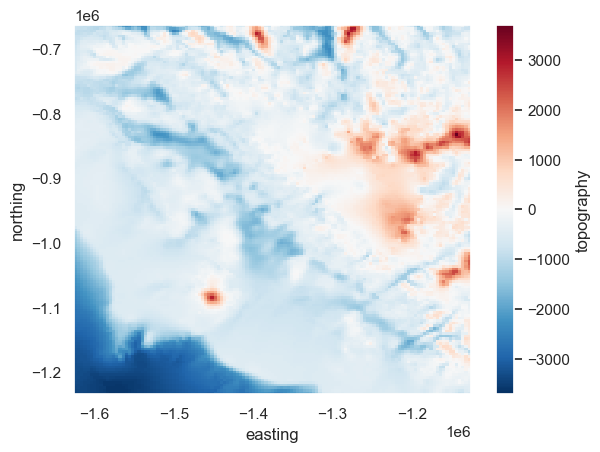

In [23]:
invs.model.topography.plot()

# 8.) Comparision

In [24]:
bed_topography2 = ptk.fetch.bedmap2(layer="bed", region=region, reference="ellipsoid", spacing=spacing)


bed_topography2 = bed_topography2.rename({'x': 'easting', 'y': 'northing'}).to_dataset(name='upward')

In [25]:
bed_topography2

<xarray.Dataset> Size: 74kB
Dimensions:   (northing: 143, easting: 125)
Coordinates:
  * northing  (northing) float64 1kB -1.232e+06 -1.228e+06 ... -6.64e+05
  * easting   (easting) float64 1kB -1.624e+06 -1.62e+06 ... -1.128e+06
Data variables:
    upward    (northing, easting) float32 72kB -3.522e+03 -3.503e+03 ... -787.6

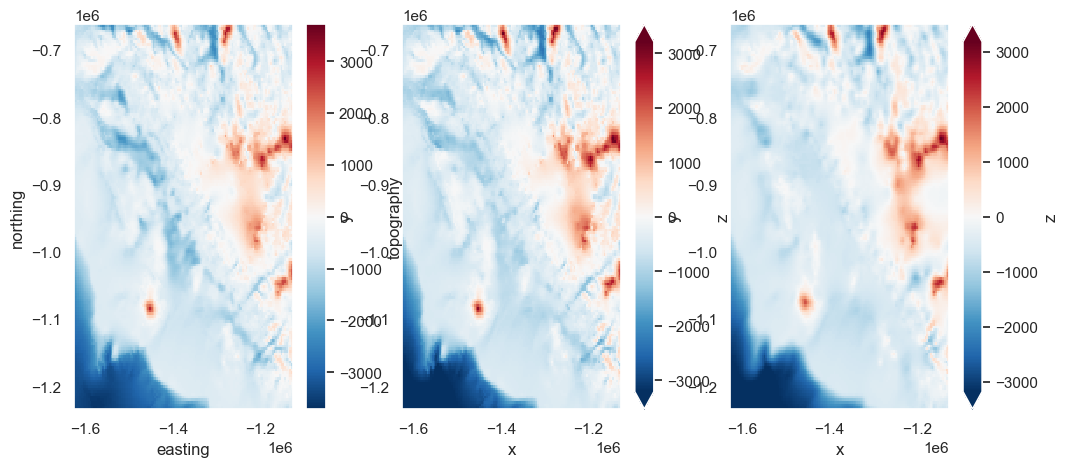

In [26]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 5))


invs.model.topography.plot(ax = ax1)

bed_topography.upward.plot.pcolormesh(x='easting', y='northing', ax=ax2, robust=True)


bed_topography2.upward.plot.pcolormesh(x='easting', y='northing', ax=ax3, robust=True)


In [27]:
invs.model.topography
invs.model.topography

<xarray.DataArray 'topography' (northing: 143, easting: 125)> Size: 143kB
array([[-3466.35190369, -3437.12968312, -3415.79563525, ...,
         -820.27083291,  -573.24408406,  -618.9040558 ],
       [-3426.29686955, -3409.70868433, -3408.43982404, ...,
         -725.45413577,  -506.58812833,  -457.20473275],
       [-3395.54287864, -3389.29038962, -3398.97319223, ...,
         -498.11621132,  -439.38479403,  -431.94692765],
       ...,
       [ -868.19121778,  -929.78156594,  -925.65919419, ...,
         -677.49432373,  -479.76977539,  -459.60458374],
       [ -800.30850684,  -838.43318527,  -883.10930073, ...,
         -669.49139404,  -792.699646  ,  -793.3620338 ],
       [ -763.91341914,  -800.85032639,  -845.11551322, ...,
         -191.26791382,  -649.96553955,  -791.78588109]], shape=(143, 125))
Coordinates:
  * northing  (northing) float64 1kB -1.232e+06 -1.228e+06 ... -6.64e+05
  * easting   (easting) float64 1kB -1.624e+06 -1.62e+06 ... -1.128e+06
    top       (northing, easting) float64 143kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bottom    (northing, easting) float64 143kB -3.466e+03 -3.437e+03 ... -791.8

In [28]:
diff1 = invs.model.topography - bed_topography

diff2 = invs.model.topography - bed_topography2


Text(0.5, 1.0, 'Difference final Topography - Bedmap2')

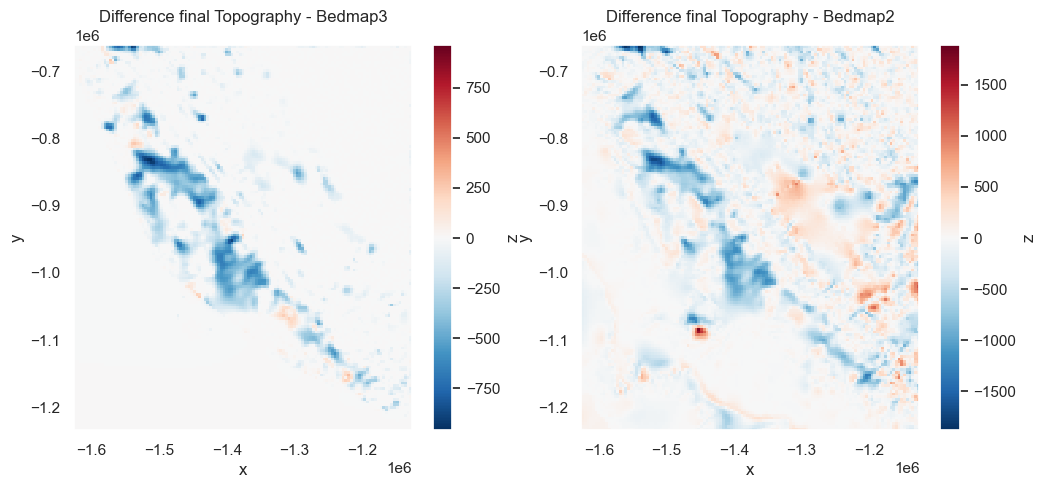

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

diff1.upward.plot.pcolormesh(ax=ax1)
ax1.set_title('Difference final Topography - Bedmap3')
diff2.upward.plot.pcolormesh(ax=ax2)
ax2.set_title('Difference final Topography - Bedmap2')